# Neural Style Transfer

### Uses deep learning to compose one image in the style of another image.

### Note: Demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style.                      Modern approaches train a model to generate the stylized image directly

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_img (tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] ==1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim
    new_shape = tf.cast(shape*scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

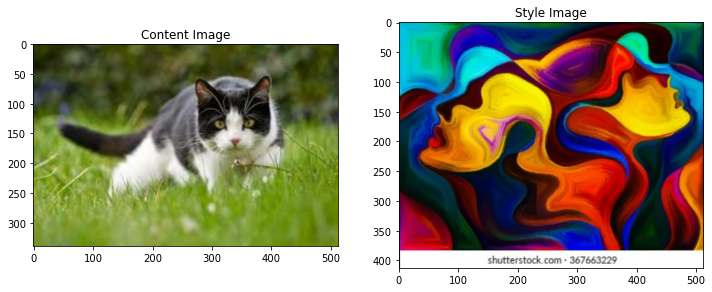

In [6]:
content_image = load_img('Data/train/CAT/5.jpg')
style_image = load_img('Data/2.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

###### To get representation of our content and style image we use intermediate layers of model. As inital layers low-level features like edges. As we go deep in network layers represent high-level features like eyes.
###### Using VGG 19 pretrained classification model for intermediate layers. 

In [7]:
x = tf.keras.applications.vgg16.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [8]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Border_collie', 0.25078738),
 ('hare', 0.13171679),
 ('English_springer', 0.1271274),
 ('Japanese_spaniel', 0.059647035),
 ('papillon', 0.035620403)]

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [10]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

### Build the model

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trianable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 413, 512, 64)
  min:  0.0
  max:  876.13245
  mean:  33.896347

block2_conv1
  shape:  (1, 206, 256, 128)
  min:  0.0
  max:  4522.5015
  mean:  150.61409

block3_conv1
  shape:  (1, 103, 128, 256)
  min:  0.0
  max:  11429.146
  mean:  175.09198

block4_conv1
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  22402.086
  mean:  613.5624

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3432.9402
  mean:  53.036366



## Calculate style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

𝐺𝑙𝑐𝑑=∑𝑖𝑗𝐹𝑙𝑖𝑗𝑐(𝑥)𝐹𝑙𝑖𝑗𝑑(𝑥)𝐼𝐽
 
This can be implemented concisely using the tf.linalg.einsum function:

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [14]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        print(self)
    
    def call(self, inputs):
        inputs = inputs*255.0
        prepocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(prepocessed_inputs)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                         outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        
        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0025312866
    max:  16444.95
    mean:  311.96338

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  60947.08
    mean:  7461.9224

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  398233.38
    mean:  7757.2886

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4485159.0
    mean:  123187.7

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  102290.48
    mean:  1050.3715

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1222.4281
    mean:  12.452037


## Run gradient descent
With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [16]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [17]:
tf.reduce_mean(style_targets['block1_conv1'])

<tf.Tensor: shape=(), dtype=float32, numpy=1345.3206>

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n(tf.reduce_mean((style_outputs[name] -style_targets[name])**2)
                         for name in style_outputs.keys())
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
#@tf.function()
def train_step(image):
 with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
 grad = tape.gradient(loss, image)
 opt.apply_gradients([(grad, image)])
 image.assign(clip_0_1(image))

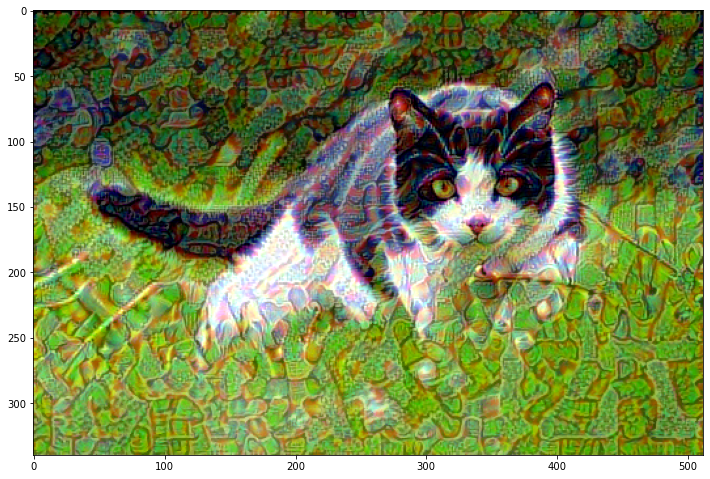

In [24]:
for i in range(10):
    train_step(image)
plt.imshow(image[0])

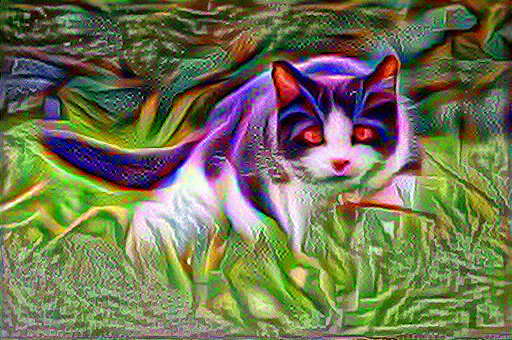

Train step : 50
Total Time: 133.8


In [25]:
import time
start = time.time()

epoches = 5
steps_per_epoch = 10
step = 0
for n in range(epoches):
    for m in range(steps_per_epoch):
        step+=1
        train_step(image)
        print('.', end='')
        display.clear_output(wait=True)
        display.display(tensor_to_img(image))
        print('Train step : {}'.format(step))
end = time.time()
print("Total Time: {:.1f}".format(end-start))

For better results increase epoches value.

## Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [26]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

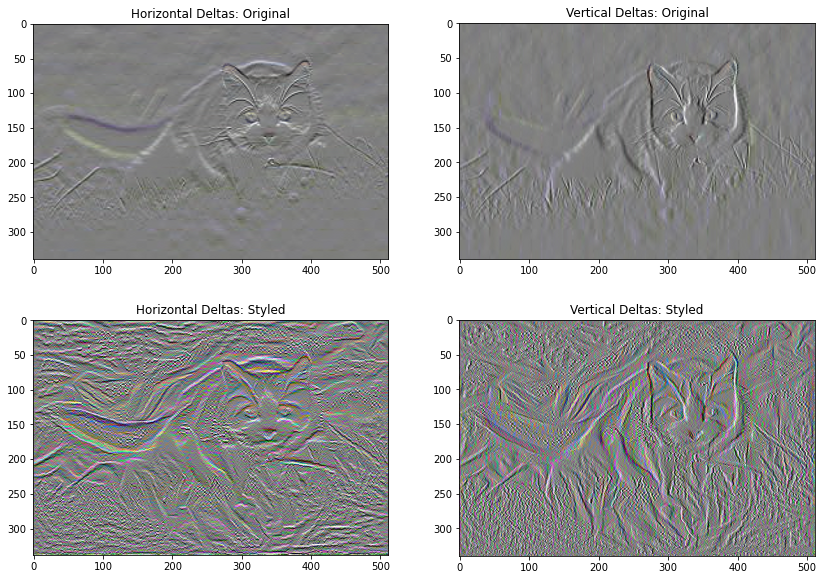

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

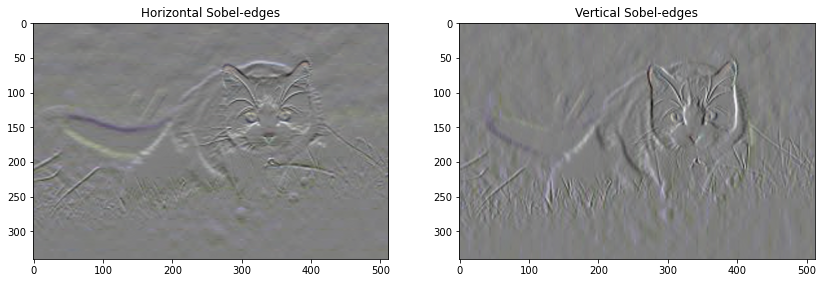

In [28]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [29]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

##### Re-run the optimization:
 Define Total Variation Weight

In [33]:
total_variation_loss(image).numpy()
total_variation_weight=20

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

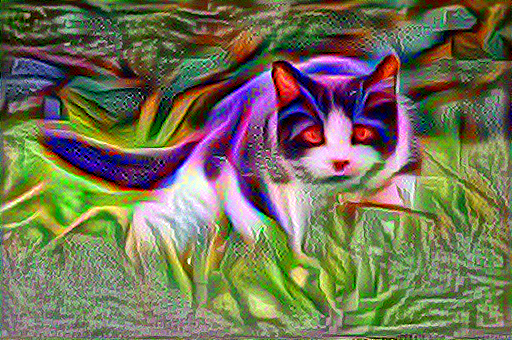

Train step : 50
Total Time: 73.8


In [35]:
import time
start = time.time()

epoches = 5
steps_per_epoch = 10
step = 0
for n in range(epoches):
    for m in range(steps_per_epoch):
        step+=1
        train_step(image)
        print('.', end='')
        display.clear_output(wait=True)
        display.display(tensor_to_img(image))
        print('Train step : {}'.format(step))
end = time.time()
print("Total Time: {:.1f}".format(end-start))